In [7]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
import numpy as np
import pandas as pd
import skfuzzy as fuzz
from skfuzzy import control as ctrl
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt

In [8]:
# 1. Baca dataset
df = pd.read_csv("./data/dataset_siswa.csv")

# Memeriksa apakah ada missing values di dataset
print("\nMissing Values per Kolom:")
print(df.isnull().sum())

# Jika ada missing values, kita bisa mengisinya dengan rata-rata kolom masing-masing
df['absensi'] = df['absensi'].fillna(df['absensi'].mean())
df['nilai'] = df['nilai'].fillna(df['nilai'].mean())

# Memeriksa kembali setelah pengisian missing values
print("\nDataset Setelah Penanganan Missing Values:")
print(df.isnull().sum())

# Menampilkan informasi dasar dari dataset
print("\nInformasi Dataset:")
print(df.info())

# Menampilkan statistik deskriptif untuk atribut numerik
print("\nStatistik Deskriptif Dataset:")
print(df.describe())


Missing Values per Kolom:
absensi    0
nilai      0
dtype: int64

Dataset Setelah Penanganan Missing Values:
absensi    0
nilai      0
dtype: int64

Informasi Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 499 entries, 0 to 498
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   absensi  499 non-null    int64
 1   nilai    499 non-null    int64
dtypes: int64(2)
memory usage: 7.9 KB
None

Statistik Deskriptif Dataset:
          absensi       nilai
count  499.000000  499.000000
mean    48.382766   49.106212
std     29.482412   28.829487
min      0.000000    0.000000
25%     22.000000   22.500000
50%     49.000000   50.000000
75%     73.000000   74.000000
max    100.000000  100.000000


In [9]:

# 2. Kategorisasi manual performa (jika belum ada kolom 'performa')
def categorize_performance(row):
    absensi = row['absensi']
    nilai = row['nilai']
    if (absensi < 40 and nilai < 40):
        return 'Buruk'
    elif (absensi < 40 and 40 <= nilai < 70):
        return 'Buruk'
    elif (40 <= absensi < 70 and nilai < 40):
        return 'Buruk'
    elif (absensi >= 70 and nilai >= 70):
        return 'Bagus'
    elif (absensi >= 70 and 40 <= nilai < 70):
        return 'Bagus'
    elif (40 <= absensi < 70 and nilai >= 70):
        return 'Bagus'
    else:
        return 'Cukup'

if 'performa' not in df.columns:
    df['performa'] = df.apply(categorize_performance, axis=1)

print("\nContoh Data Setelah Prapemrosesan:")
print(df.head(20))


Contoh Data Setelah Prapemrosesan:
    absensi  nilai performa
0        37     40    Buruk
1         1      1    Buruk
2        42     24    Buruk
3        51     12    Buruk
4        88      3    Cukup
5         0     43    Buruk
6        30     15    Buruk
7        56     78    Bagus
8        44     99    Bagus
9        49     23    Buruk
10       98     33    Cukup
11      100     47    Bagus
12       70     76    Bagus
13        0     48    Buruk
14       36     65    Buruk
15       79     85    Bagus
16       78     79    Bagus
17       40    100    Bagus
18       13     44    Buruk
19       88     65    Bagus


In [10]:
# 3. --------- MAMDANI (skfuzzy) ---------
absensi_fz = ctrl.Antecedent(np.arange(0, 101, 1), 'absensi')
nilai_fz = ctrl.Antecedent(np.arange(0, 101, 1), 'nilai')
performa_fz = ctrl.Consequent(np.arange(0, 1.01, 0.01), 'performa')

absensi_fz['rendah'] = fuzz.gaussmf(absensi_fz.universe, 0, 15)
absensi_fz['sedang'] = fuzz.gaussmf(absensi_fz.universe, 50, 15)
absensi_fz['tinggi'] = fuzz.gaussmf(absensi_fz.universe, 100, 15)

nilai_fz['rendah'] = fuzz.gaussmf(nilai_fz.universe, 0, 15)
nilai_fz['sedang'] = fuzz.gaussmf(nilai_fz.universe, 50, 15)
nilai_fz['tinggi'] = fuzz.gaussmf(nilai_fz.universe, 100, 15)

performa_fz['buruk'] = fuzz.gaussmf(performa_fz.universe, 0, 0.15)
performa_fz['cukup'] = fuzz.gaussmf(performa_fz.universe, 0.5, 0.15)
performa_fz['bagus'] = fuzz.gaussmf(performa_fz.universe, 1, 0.15)

rule1 = ctrl.Rule(absensi_fz['rendah'] & nilai_fz['rendah'], performa_fz['buruk'])
rule2 = ctrl.Rule(absensi_fz['rendah'] & nilai_fz['sedang'], performa_fz['buruk'])
rule3 = ctrl.Rule(absensi_fz['rendah'] & nilai_fz['tinggi'], performa_fz['cukup'])
rule4 = ctrl.Rule(absensi_fz['sedang'] & nilai_fz['rendah'], performa_fz['buruk'])
rule5 = ctrl.Rule(absensi_fz['sedang'] & nilai_fz['sedang'], performa_fz['cukup'])
rule6 = ctrl.Rule(absensi_fz['sedang'] & nilai_fz['tinggi'], performa_fz['bagus'])
rule7 = ctrl.Rule(absensi_fz['tinggi'] & nilai_fz['rendah'], performa_fz['cukup'])
rule8 = ctrl.Rule(absensi_fz['tinggi'] & nilai_fz['sedang'], performa_fz['bagus'])
rule9 = ctrl.Rule(absensi_fz['tinggi'] & nilai_fz['tinggi'], performa_fz['bagus'])

performa_ctrl = ctrl.ControlSystem([rule1, rule2, rule3, rule4, rule5, rule6, rule7, rule8, rule9])
performa_simulasi = ctrl.ControlSystemSimulation(performa_ctrl)

def map_fuzzy_label(score, th_buruk=0.33, th_bagus=0.66):
    if score < th_buruk:
        return "Buruk"
    elif score > th_bagus:
        return "Bagus"
    else:
        return "Cukup"

fuzzy_scores = []
fuzzy_labels = []
for idx, row in df.iterrows():
    performa_simulasi.input['absensi'] = row['absensi']
    performa_simulasi.input['nilai'] = row['nilai']
    performa_simulasi.compute()
    score = performa_simulasi.output['performa']
    fuzzy_scores.append(score)
    fuzzy_labels.append(map_fuzzy_label(score))

df['mamdani_score'] = fuzzy_scores
df['mamdani_label'] = fuzzy_labels

accuracy_mamdani = accuracy_score(df['performa'], df['mamdani_label'])
f1_mamdani = f1_score(df['performa'], df['mamdani_label'], average='weighted', labels=['Buruk', 'Cukup', 'Bagus'], zero_division=1)


In [11]:
# 4. --------- SUGENO (manual) ---------
def gaussian_membership(x, center, sigma):
    return np.exp(-0.5 * ((x - center) / sigma) ** 2)

def sugeno(absensi, nilai):
    absensi_rendah = gaussian_membership(absensi, 0, 15)
    absensi_sedang = gaussian_membership(absensi, 50, 15)
    absensi_tinggi = gaussian_membership(absensi, 100, 15)

    nilai_rendah = gaussian_membership(nilai, 0, 15)
    nilai_sedang = gaussian_membership(nilai, 50, 15)
    nilai_tinggi = gaussian_membership(nilai, 100, 15)

    OUTPUT_BURUK = 0.0
    OUTPUT_CUKUP = 0.5
    OUTPUT_BAGUS = 1.0

    alpha_rule1 = min(absensi_rendah, nilai_rendah)
    alpha_rule2 = min(absensi_rendah, nilai_sedang)
    alpha_rule3 = min(absensi_rendah, nilai_tinggi)
    alpha_rule4 = min(absensi_sedang, nilai_rendah)
    alpha_rule5 = min(absensi_sedang, nilai_sedang)
    alpha_rule6 = min(absensi_sedang, nilai_tinggi)
    alpha_rule7 = min(absensi_tinggi, nilai_rendah)
    alpha_rule8 = min(absensi_tinggi, nilai_sedang)
    alpha_rule9 = min(absensi_tinggi, nilai_tinggi)

    numerator = (alpha_rule1 * OUTPUT_BURUK) + \
                (alpha_rule2 * OUTPUT_BURUK) + \
                (alpha_rule3 * OUTPUT_CUKUP) + \
                (alpha_rule4 * OUTPUT_BURUK) + \
                (alpha_rule5 * OUTPUT_CUKUP) + \
                (alpha_rule6 * OUTPUT_BAGUS) + \
                (alpha_rule7 * OUTPUT_CUKUP) + \
                (alpha_rule8 * OUTPUT_BAGUS) + \
                (alpha_rule9 * OUTPUT_BAGUS)
    denominator = alpha_rule1 + alpha_rule2 + alpha_rule3 + \
                  alpha_rule4 + alpha_rule5 + alpha_rule6 + \
                  alpha_rule7 + alpha_rule8 + alpha_rule9

    if denominator == 0:
        return OUTPUT_CUKUP
    else:
        return numerator / denominator

def map_sugeno_label(score, th_buruk=0.33, th_bagus=0.66):
    if score < th_buruk:
        return "Buruk"
    elif score > th_bagus:
        return "Bagus"
    else:
        return "Cukup"

sugeno_scores = []
sugeno_labels = []
for idx, row in df.iterrows():
    score = sugeno(row['absensi'], row['nilai'])
    sugeno_scores.append(score)
    sugeno_labels.append(map_sugeno_label(score))

df['sugeno_score'] = sugeno_scores
df['sugeno_label'] = sugeno_labels

accuracy_sugeno = accuracy_score(df['performa'], df['sugeno_label'])
f1_sugeno = f1_score(df['performa'], df['sugeno_label'], average='weighted', labels=['Buruk', 'Cukup', 'Bagus'], zero_division=1)

=== Evaluasi Metode Mamdani (skfuzzy) ===
Accuracy: 0.7675
F1-Score: 0.7734

=== Evaluasi Metode Sugeno (manual) ===
Accuracy: 0.8357
F1-Score: 0.8350

Sugeno lebih baik berdasarkan akurasi.


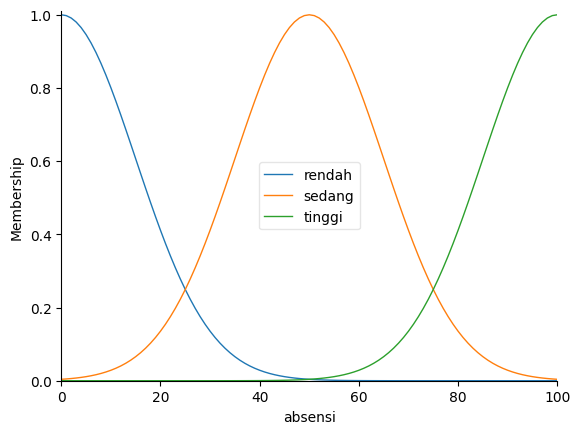

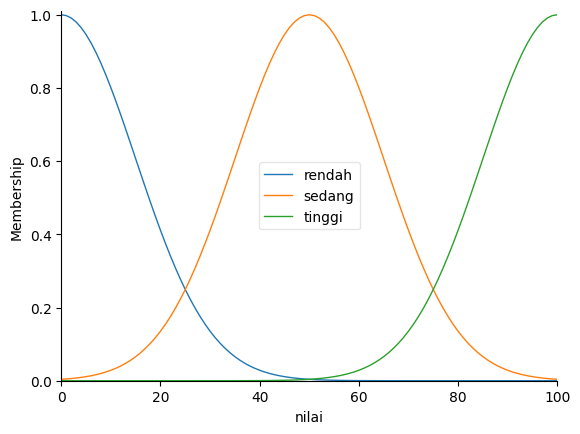

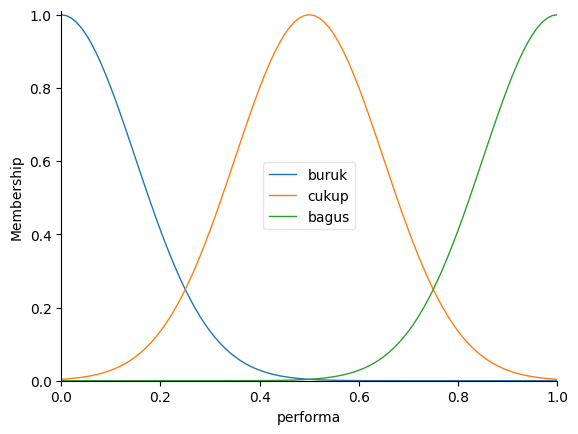

In [12]:
# 5. --------- HASIL PERBANDINGAN ---------
print("=== Evaluasi Metode Mamdani (skfuzzy) ===")
print(f"Accuracy: {accuracy_mamdani:.4f}")
print(f"F1-Score: {f1_mamdani:.4f}")

print("\n=== Evaluasi Metode Sugeno (manual) ===")
print(f"Accuracy: {accuracy_sugeno:.4f}")
print(f"F1-Score: {f1_sugeno:.4f}")

if accuracy_mamdani > accuracy_sugeno:
    print("\nMamdani lebih baik berdasarkan akurasi.")
elif accuracy_mamdani < accuracy_sugeno:
    print("\nSugeno lebih baik berdasarkan akurasi.")
else:
    print("\nKedua metode memiliki akurasi yang sama.")

absensi_fz.view()
nilai_fz.view()
performa_fz.view()